In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import empyrical as emp
import yfinance as yf

# download DJIA stock price data (29 out of 30)
stocks = [
    'AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
    'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
    'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'
]
start_date = '2016-01-01'
end_date = '2022-01-01'
prices = yf.download(stocks, start = start_date, end = end_date)[['Adj Close']]

prices.dropna(axis='columns', inplace=True)
prices.columns = prices.columns.droplevel(0)

# compute log returns
log_returns = prices.apply(np.log).apply(np.diff)
log_returns.index = prices.index[:-1]
# compute linear returns
prices_mat = np.ascontiguousarray(prices)
linear_returns = np.diff(prices_mat, axis=0) / prices_mat[:-1]


[*********************100%***********************]  29 of 29 completed


In [2]:
prices.describe()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
count,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,...,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000
mean,64.871240,173.777066,98.924816,239.389584,124.296202,150.144765,37.299717,89.281275,122.095893,216.347067,...,59.760613,133.180596,85.024676,95.045605,118.248980,240.918316,145.005487,43.821268,53.641887,96.779846
std,41.505419,35.591909,31.391140,88.498936,43.990550,63.478850,9.852719,12.312109,29.583403,67.073878,...,11.848944,78.774241,34.979928,25.469874,17.816139,90.106331,52.581990,6.142887,10.820118,28.684850
min,20.883036,111.723976,45.823311,95.010002,47.813442,54.049999,17.914143,47.194569,83.824921,122.750298,...,37.039524,43.927299,46.305202,60.670288,76.222900,97.952347,64.502182,31.436886,30.098465,52.382469
25%,35.775072,145.130203,75.461113,164.872185,92.114559,89.654999,27.383616,80.176567,99.657448,180.103928,...,48.942999,66.177086,54.751411,72.837635,105.185928,171.170868,92.274837,37.682903,45.218552,70.534863
50%,46.313225,167.003052,94.163872,226.300980,120.677231,146.970001,38.377701,91.778580,110.119598,201.583939,...,62.608250,105.051910,77.064392,83.239258,115.923271,232.593964,139.829773,45.700314,53.767143,91.501953
75%,90.572353,208.416031,114.734745,330.382156,137.579048,189.529999,43.465435,99.617718,138.993561,223.866714,...,70.617462,196.938202,98.813713,116.086472,130.690285,289.630875,193.196457,49.533337,64.101624,123.173702
max,179.016113,243.333191,183.367386,430.299988,234.190857,309.959991,61.063248,113.655006,201.910004,407.866791,...,86.295822,339.075562,174.809555,158.222977,157.794540,497.415375,247.784683,54.233448,72.284973,147.901993


In [3]:
prices.columns

Index(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS',
       'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK',
       'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'],
      dtype='object')

<Axes: title={'center': 'Normalized prices'}, xlabel='Date'>

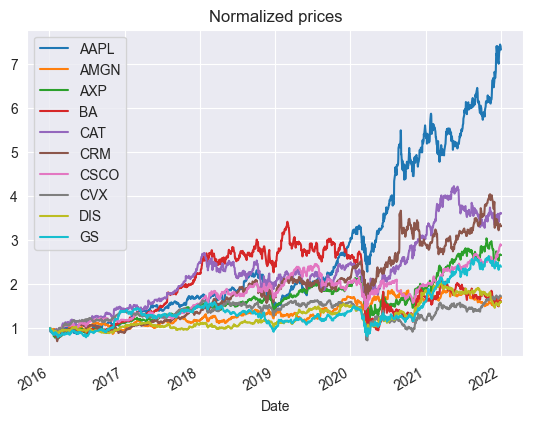

In [4]:
prices.div(prices.iloc[0]).iloc[:, :10].plot(title="Normalized prices")

In [5]:
T, N = np.shape(log_returns)
T_trn = int(0.7*T)
log_returns_mat = np.ascontiguousarray(log_returns)
log_returns_train = log_returns_mat[:T_trn,]
log_returns_test = log_returns_mat[T_trn:,]
lin_returns_train = linear_returns[:T_trn,]
lin_returns_test = linear_returns[T_trn:,]

In [6]:
mu = np.mean(log_returns_train, axis=0)
Sigma = np.cov(log_returns_train.T)

In [7]:
len(mu)

29

#### Non graph based methods

In [8]:
import cvxpy as cp  # interface for convex optimization solvers

# define portfolio formulations
def compute_markowitz_portfolio(mu, Sigma, lmd = 0.5):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    #exp_return = np.sum(w * mu)
    exp_return = w @ mu
    problem = cp.Problem(cp.Minimize(variance - lmd * exp_return),
                         [w >= 0, cp.sum(w) == 1])
    problem.solve()
    return w.value

def compute_GMVP(Sigma):    
    w = cp.Variable(np.shape(Sigma)[0])
    variance = cp.quad_form(w, Sigma)
    problem = cp.Problem(cp.Minimize(variance),
                         [w >= 0, cp.sum(w) == 1])
    problem.solve()
    return w.value

def compute_RPP(Sigma):    
    # compute naive RPP
    sigma2 = np.diag(Sigma)
    w_RPP_naive = 1/np.sqrt(sigma2)
    w_RPP_naive = w_RPP_naive/np.sum(w_RPP_naive)
    return w_RPP_naive

def compute_EWP(N, selected_assets=None):
    if selected_assets is None or len(selected_assets) == 0:
        return np.ones(N)/ N 
    stock_idx = np.array(list(selected_assets))
    w_EWP = np.zeros(N)
    w_EWP[stock_idx] = 1/ len(selected_assets)
    return w_EWP

#### Centrality Based Method 

In [9]:
import networkx as nx

# Graph model functions
def create_stock_graph(log_returns, correlation_threshold):
    correlation_matrix = log_returns.corr()
    correlation_matrix.values[np.tril_indices_from(correlation_matrix)] = 0
    correlation_matrix = correlation_matrix.abs()
    stock_graph = nx.from_numpy_array(correlation_matrix.values)
    stock_graph.remove_edges_from([(u, v) for u, v, d in stock_graph.edges(data=True) if d['weight'] < correlation_threshold])
    return stock_graph

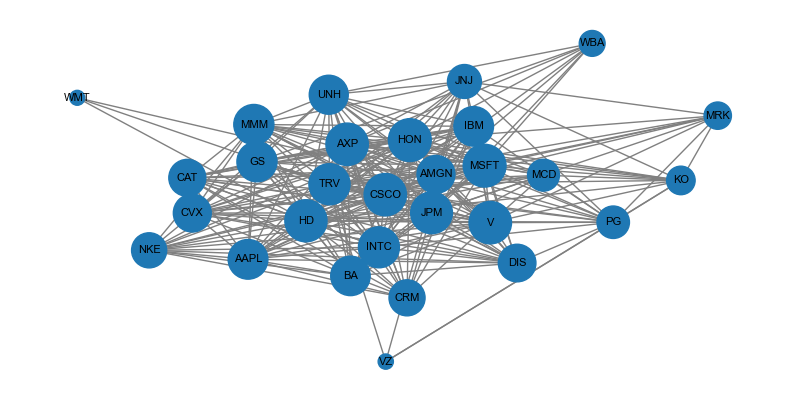

In [10]:
stock_graph = create_stock_graph(log_returns.iloc[:T_trn,], .435)
# draw the graph
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
deg_cen = nx.eigenvector_centrality_numpy(stock_graph)
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*v for v in deg_cen.values()])
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

##### Degeneracy Ordering

In [11]:
# A k-core is a maximal subgraph that contains nodes of degree k or more.
# The core number of a node is the largest value k of a k-core containing that node.

def compute_degen(stock_graph):
    # Get degeneracy ordering in linear time.
    ordering = nx.algorithms.core_number(stock_graph)
    # Compute the degeneracy ordering of the graph
    selected_vertices = set()

    # Iterate over the nodes in the degeneracy ordering
    for node in sorted(ordering, key=ordering.get):
        # Check if the node is adjacent to any previously selected vertices
        if not any(node in stock_graph.neighbors(v) for v in selected_vertices):
            # Add the node to the set of selected vertices
            selected_vertices.add(node)

    # Print the selected vertices
    #print(selected_vertices)
    w_degen = compute_EWP(N, selected_vertices)
    #print(w_degen)
    return w_degen
    

In [12]:
# Parameter selection 
thresholds = np.linspace(0.4, 0.7, 21)
tmp_sharpe_ratios = {}
for threshold in thresholds:
    stock_graph_tmp = create_stock_graph(log_returns.iloc[:T_trn,], threshold)
    w_degen = compute_degen(stock_graph_tmp)
    # compute returns of degeneracy ordering
    ret_all = linear_returns @ w_degen
    ret_all_trn = ret_all[:T_trn, ]
    tmp_sharpe_ratios[threshold] = emp.sharpe_ratio(ret_all_trn) # performance in-sample

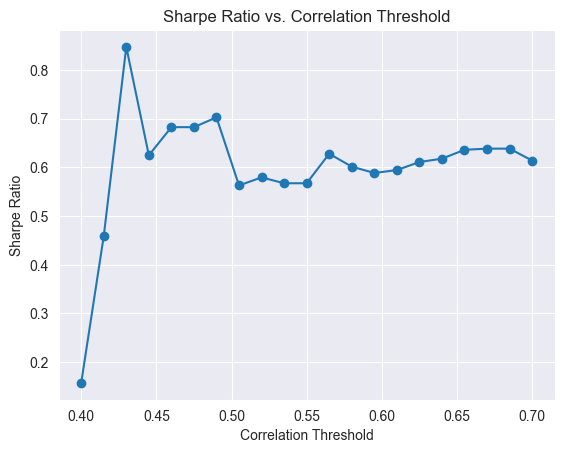

In [13]:
# Plot the Sharpe Ratios as a function of the correlation threshold
plt.plot(tmp_sharpe_ratios.keys(), tmp_sharpe_ratios.values(), 'o-')
plt.xlabel('Correlation Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. Correlation Threshold')
plt.show()

In [14]:
# Get degeneracy ordering in linear time.
ordering = nx.algorithms.core_number(stock_graph)
# Compute the degeneracy ordering of the graph
selected_vertices = set()

# Iterate over the nodes in the degeneracy ordering
for node in sorted(ordering, key=ordering.get):
    # Check if the node is adjacent to any previously selected vertices
    neighbors = stock_graph.neighbors(node)
    if not any(v in neighbors for v in selected_vertices):
        # Add the node to the set of selected vertices
        selected_vertices.add(node)

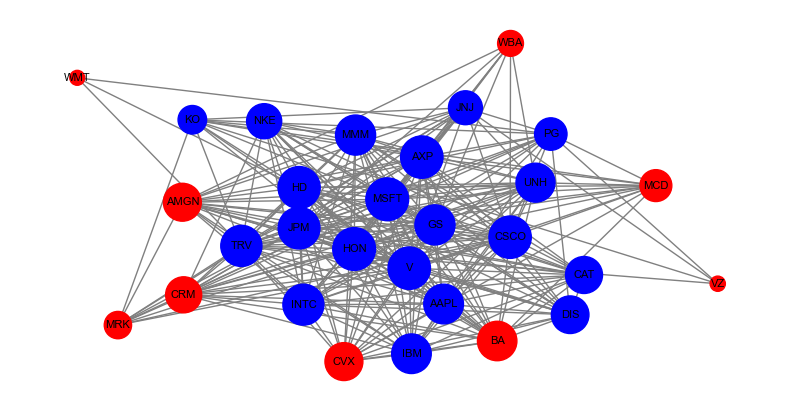

In [15]:
# draw the graph with color
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
node_colors = ['red' if i in selected_vertices else 'blue' for i in stock_graph.nodes()]
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*v for v in deg_cen.values()], node_color=node_colors)
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

##### Clique Centrality

In [16]:
from collections import Counter

def compute_cliques(stock_graph):
    # Compute the maximal cliques of the graph
    cliques = nx.find_cliques(stock_graph)

    # Compute the cross maximal clique centrality of each vertex
    centrality = Counter()
    for clique in cliques:
        centrality.update(clique)

    # Select vertices with cross maximal clique centrality above a threshold
    threshold = 10  # example threshold value
    selected_vertices = set(node for node in stock_graph.nodes() if centrality[node] >= threshold)

    # Print the selected vertices
    #print(selected_vertices)
    w_cliques = compute_EWP(N, selected_vertices)
    #print(w_cliques)
    return w_cliques

In [17]:
# Compute the maximal cliques of the graph
cliques = nx.find_cliques(stock_graph)

# Compute the cross maximal clique centrality of each vertex
centrality = Counter()
for clique in cliques:
    centrality.update(clique)

# Select vertices with cross maximal clique centrality above a threshold
threshold = 10  # example threshold value
selected_vertices = set(node for node in stock_graph.nodes() if centrality[node] >= threshold)

# Print the selected vertices
print(selected_vertices)
w_cliques = compute_EWP(N, selected_vertices)

{2, 6, 9, 10, 11, 13, 15, 20, 22, 23, 25}


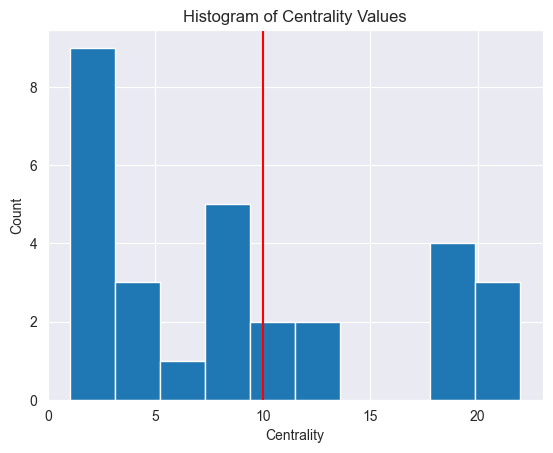

In [18]:
plt.hist(centrality.values())
# add x-axis label, y-axis label, and title
plt.xlabel('Centrality')
plt.ylabel('Count')
plt.title('Histogram of Centrality Values')

# add vertical line at x=10
plt.axvline(x=10, color='red')

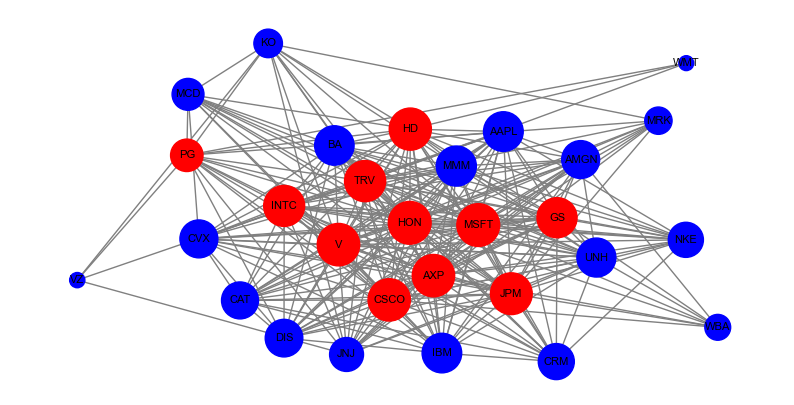

In [19]:
# draw the graph with color
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
deg_cen = nx.eigenvector_centrality_numpy(stock_graph)
node_colors = ['red' if i in selected_vertices else 'blue' for i in stock_graph.nodes()]
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*v for v in deg_cen.values()], node_color=node_colors)
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

#### Clustering Based Method

##### Centrality Based Clustering

In [20]:
# Compute the Eigenvector Centrality measure for each stock
deg_cen = nx.eigenvector_centrality_numpy(stock_graph)

# Convert the centrality dictionary into a pandas dataframe
centrality_df = pd.DataFrame.from_dict(deg_cen, orient='index', columns=['Centrality'])

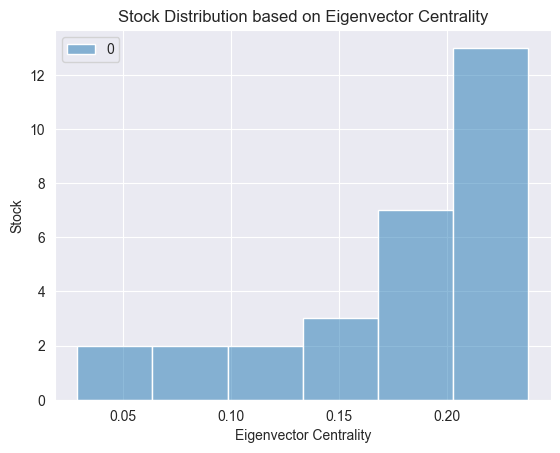

In [21]:
# Create a histogram for centrality distribution
sns.histplot(deg_cen.values())

# Set the plot title and axis labels
plt.title('Stock Distribution based on Eigenvector Centrality')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Stock')

# Show the plot
plt.show()

In [22]:
from sklearn.cluster import KMeans

# Apply K-means clustering to group stocks based on their centrality measures
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=20230427, n_init="auto").fit(centrality_df)
centrality_df['Cluster'] = kmeans.labels_
cluster_counter = centrality_df.Cluster.value_counts().to_dict()

# Assign equal weight to each stock in each cluster and equal weight to each cluster
cluster_weights = 1 / num_clusters
w_ec = centrality_df['Cluster'].apply(lambda idx: 1/ cluster_counter[idx] * cluster_weights)

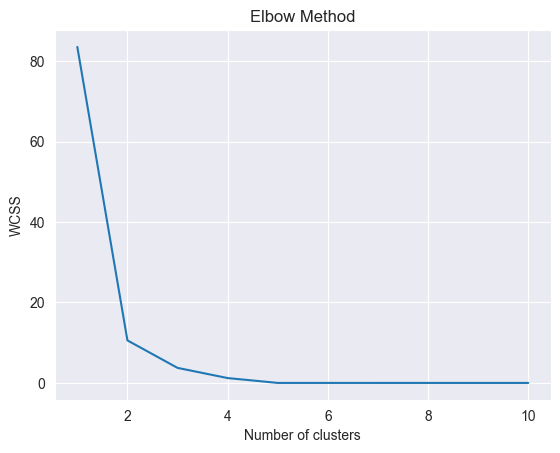

In [23]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=20230427, n_init="auto")
    kmeans.fit(centrality_df)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
def compute_ec(stock_graph):
    # Compute the Eigenvector Centrality measure for each stock
    deg_cen = nx.eigenvector_centrality_numpy(stock_graph)

    # Convert the centrality dictionary into a pandas dataframe
    centrality_df = pd.DataFrame.from_dict(deg_cen, orient='index', columns=['Centrality'])    
    # Apply K-means clustering to group stocks based on their centrality measures
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=20230427, n_init="auto").fit(centrality_df)
    centrality_df['Cluster'] = kmeans.labels_
    cluster_counter = centrality_df.Cluster.value_counts().to_dict()

    # Assign equal weight to each stock in each cluster and equal weight to each cluster
    cluster_weights = 1 / num_clusters
    w_ec = centrality_df['Cluster'].apply(lambda idx: 1/ cluster_counter[idx] * cluster_weights)
    return w_ec

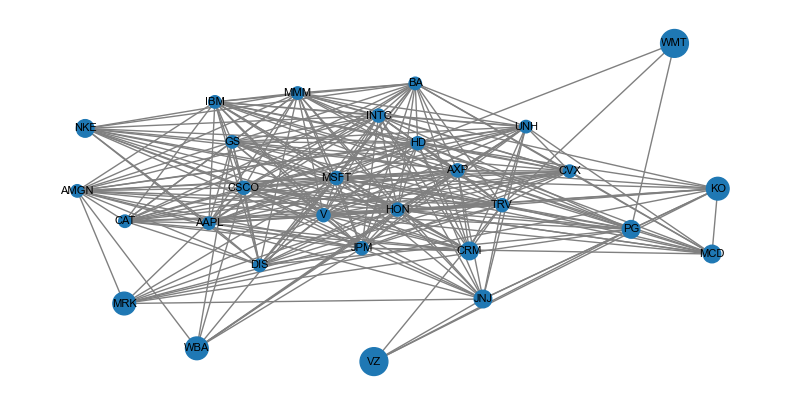

In [25]:
# draw the graph with color
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*w for w in w_ec])
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

##### Graph Spectral Clustering

In [26]:
# Calculate Laplacian matrix
laplacian_matrix = nx.normalized_laplacian_matrix(stock_graph)

# Perform eigenvalue decomposition on Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix.toarray())

# Use eigenvectors to perform Graph Spectral Clustering
sc = KMeans(n_clusters=num_clusters, random_state=20230427, n_init="auto")
sc.fit(eigenvectors[:, np.where(eigenvalues>0)[0]][:, :5])

#Assign equal weight within and between clusters
cluster_weights = 1 / num_clusters
cluster_counter = Counter(sc.labels_)
w_gsc = [1/cluster_counter[i] * cluster_weights for i in sc.labels_]

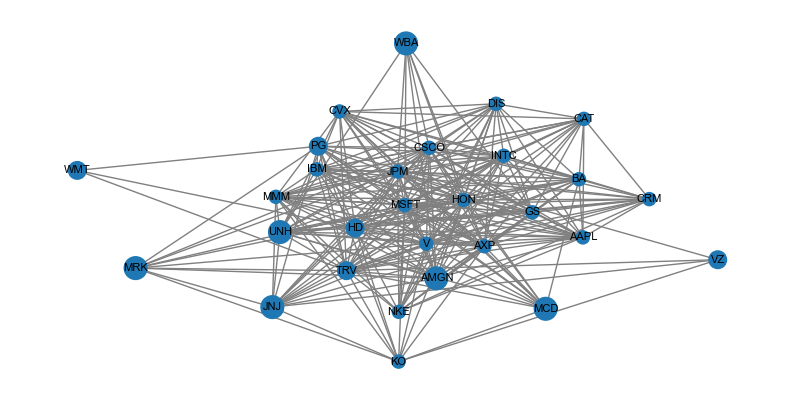

In [27]:
# draw the graph
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*w for w in w_gsc])
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

In [28]:
def compute_gsc(stock_graph):
    # Calculate Laplacian matrix
    laplacian_matrix = nx.normalized_laplacian_matrix(stock_graph)

    # Perform eigenvalue decomposition on Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix.toarray())

    # Use eigenvectors to perform Graph Spectral Clustering
    sc = KMeans(n_clusters=num_clusters, random_state=20230427, n_init="auto")
    sc.fit(eigenvectors[:, np.where(eigenvalues>0)[0]][:, :5])

    #Assign equal weight within and between clusters
    cluster_weights = 1 / num_clusters
    cluster_counter = Counter(sc.labels_)
    w_gsc = [1/cluster_counter[i] * cluster_weights for i in sc.labels_]
    return w_gsc

##### Hierarchical Clustering

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree

# Calculate correlation matrix
correlation_matrix = log_returns.iloc[:T_trn,].corr()

# Calculate dissimilarity matrix
dissimilarity_matrix = np.sqrt(2*(1 - correlation_matrix))

# Perform hierarchical clustering
linkage_matrix = linkage(dissimilarity_matrix, method='complete')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10124\3000217128.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dissimilarity_matrix, method='complete')


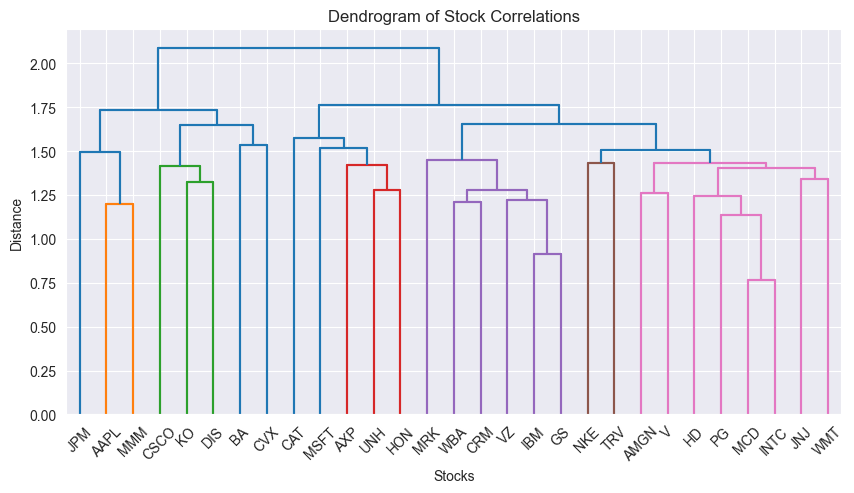

In [30]:
# Define function to replace node ids with stock names
def replace_node_ids_with_stock_names(ivl, stock_names):
    return [stock_names[int(node_id)] if node_id.isdigit() else node_id for node_id in ivl]

# Replace node ids with stock names
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(linkage_matrix)
dn = dendrogram(linkage_matrix, labels=replace_node_ids_with_stock_names(dn['ivl'], stocks))
plt.title('Dendrogram of Stock Correlations')
plt.xlabel('Stocks')
plt.ylabel('Distance')
plt.show()

In [31]:
# Define function to traverse tree and extract unique paths
def extract_paths(node, path, paths):
    if node.is_leaf():
        paths.append(path + [node.id])
    else:
        extract_paths(node.left, path + [node.id], paths)
        extract_paths(node.right, path + [node.id], paths)

# Convert linkage matrix to tree structure
root = to_tree(linkage_matrix)

# Extract unique paths from root to leaf nodes
paths = []
extract_paths(root, [], paths)

# Calculate final weight using waterfall approach 
w_hierarchy_tmp = {}
for path in paths:
    w_hierarchy_tmp[path[-1]] = .5**(len(path)-1)
w_hc = [w_hierarchy_tmp[i] for i in range(N)]

In [32]:
def compute_hc(log_returns):
    # Calculate correlation matrix
    correlation_matrix = log_returns.corr()

    # Calculate dissimilarity matrix
    dissimilarity_matrix = np.sqrt(2*(1 - correlation_matrix))

    # Perform hierarchical clustering
    linkage_matrix = linkage(dissimilarity_matrix, method='complete')

    # Convert linkage matrix to tree structure
    root = to_tree(linkage_matrix)
    # Extract unique paths from root to leaf nodes
    paths = []
    extract_paths(root, [], paths)

    # Calculate final weight using waterfall approach 
    w_hierarchy_tmp = {}
    for path in paths:
        w_hierarchy_tmp[path[-1]] = .5**(len(path)-1)
    w_hc = [w_hierarchy_tmp[i] for i in range(N)]

    return w_hc

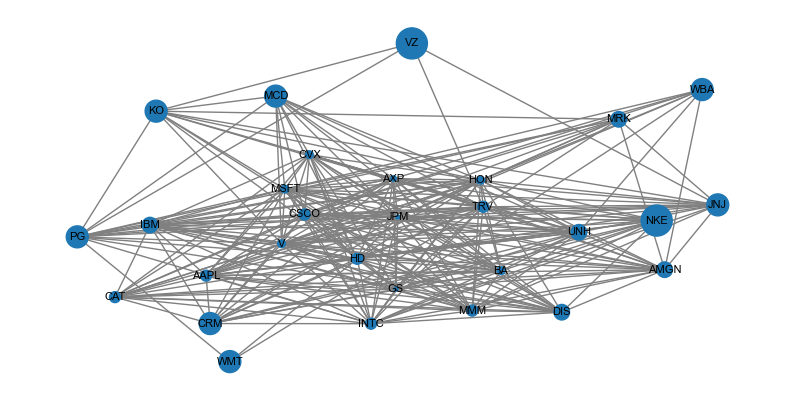

In [33]:
# draw the graph
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*w for w in w_hc])
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

#### Model Evaluation

In [34]:
# compute portfolios
w_markowitz = compute_markowitz_portfolio(mu, Sigma)
w_GMVP = compute_GMVP(Sigma)
w_EWP = compute_EWP(N)
w_RPP_naive = compute_RPP(Sigma)

c:\Users\Administrator\Documents\Python-Scripts\IEDA\3180\.venv\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


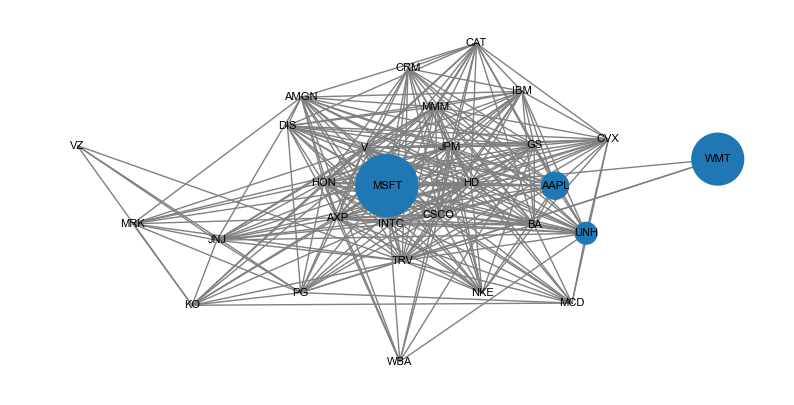

In [35]:
# draw the graph (markowitz)
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*w for w in w_markowitz])
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

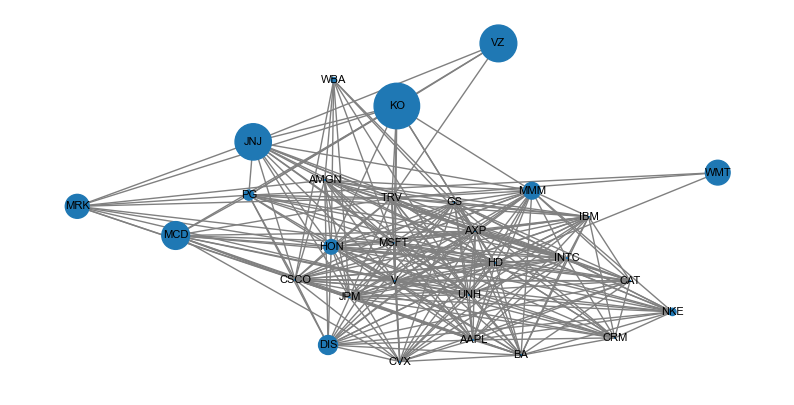

In [36]:
# draw the graph (GMVP)
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*w for w in w_GMVP])
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

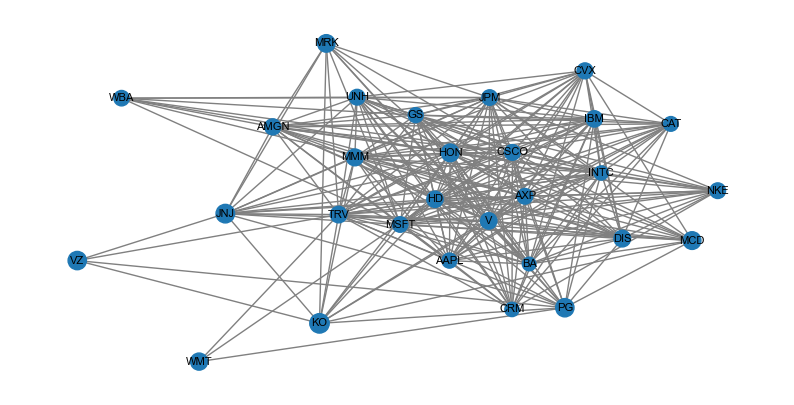

In [37]:
# draw the graph (RPP)
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.spring_layout(stock_graph, k=1.5, iterations=50)
nx.draw_networkx_nodes(stock_graph, pos, node_size=[4e3*w for w in w_RPP_naive])
nx.draw_networkx_edges(stock_graph, pos, edge_color='gray')
nx.draw_networkx_labels(stock_graph, pos, 
                        labels={i: stock for i, stock in enumerate(log_returns.columns)},
                        font_size=8, font_family='sans-serif'
)
plt.axis('off')
plt.show()

<Axes: title={'center': 'Portfolio allocation'}>

<Figure size 2000x1000 with 0 Axes>

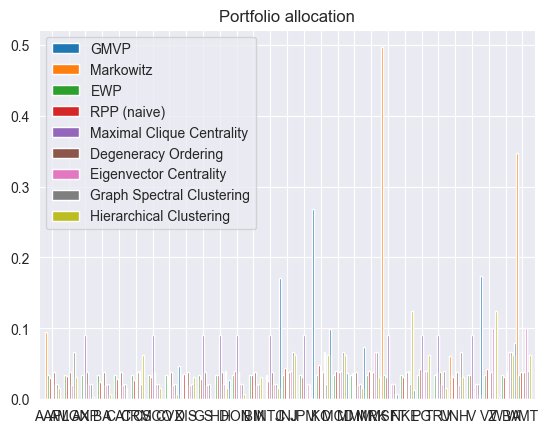

In [38]:
# put together all portfolios
portfolios = pd.DataFrame(
    np.ascontiguousarray([
        w_GMVP, w_markowitz, w_EWP, w_RPP_naive,
        w_cliques, w_degen, w_ec, w_gsc, w_hc
    ]).T,
    columns=[
        'GMVP', 'Markowitz', 'EWP', 'RPP (naive)',
        'Maximal Clique Centrality', 'Degeneracy Ordering', 'Eigenvector Centrality',
        'Graph Spectral Clustering', 'Hierarchical Clustering'
    ], index=stocks)

plt.figure(figsize=(20, 10))
# plot
portfolios.plot.bar(rot=0, width=1, title="Portfolio allocation")

In [39]:
# compute returns of all portfolios
ret_all = linear_returns @ portfolios
ret_all_trn = ret_all.iloc[:T_trn, ]
ret_all_tst = ret_all.iloc[T_trn:, ]

emp.annual_return(ret_all_trn) # performance in-sample

GMVP                         0.095875
Markowitz                    0.262048
EWP                          0.104868
RPP (naive)                  0.104255
Maximal Clique Centrality    0.122614
Degeneracy Ordering          0.092626
Eigenvector Centrality       0.106094
Graph Spectral Clustering    0.104407
Hierarchical Clustering      0.098859
dtype: float64

In [40]:
emp.annual_return(ret_all_tst) # performance out-of-sample

GMVP                         0.184373
Markowitz                    0.449268
EWP                          0.363601
RPP (naive)                  0.345571
Maximal Clique Centrality    0.412681
Degeneracy Ordering          0.357660
Eigenvector Centrality       0.287932
Graph Spectral Clustering    0.322181
Hierarchical Clustering      0.300780
dtype: float64

In [41]:
emp.sharpe_ratio(ret_all_trn) # sharpe-ratio in-sample

array([0.74067397, 1.24843889, 0.66955232, 0.68365352, 0.68878971,
       0.61398855, 0.72417064, 0.69283494, 0.69445936])

In [42]:
emp.sharpe_ratio(ret_all_tst) # sharpe-ratio out-of-sample

array([1.06755801, 1.87428552, 1.5640431 , 1.54261269, 1.57653188,
       1.55868256, 1.46387375, 1.52045366, 1.56365496])

In [43]:
emp.annual_volatility(ret_all_trn) # performance in-sample

array([0.1362487 , 0.2030107 , 0.17110835, 0.16530916, 0.19617888,
       0.16742674, 0.15627435, 0.1626536 , 0.15272097])

In [44]:
emp.annual_volatility(ret_all_tst) # performance out-of-sample

array([0.17239068, 0.20978957, 0.21270391, 0.20614438, 0.23691568,
       0.21030832, 0.18445621, 0.1963224 , 0.17832804])

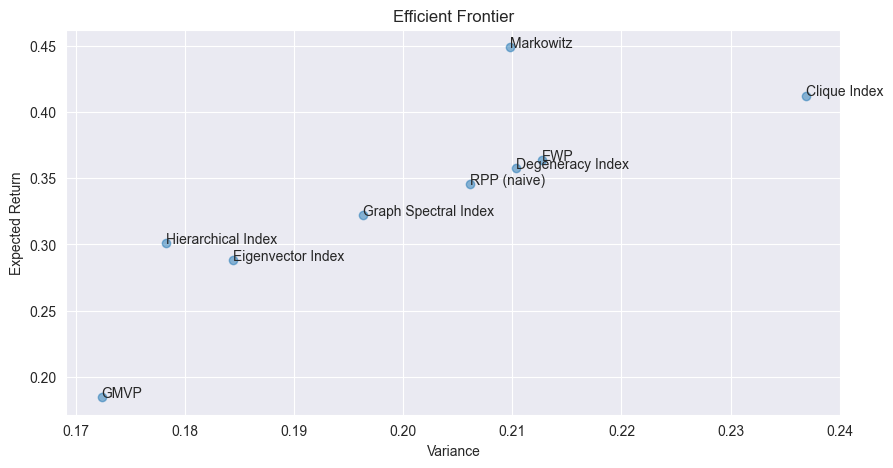

In [45]:
returns = emp.annual_return(ret_all_tst)
variances = emp.annual_volatility(ret_all_tst)
# Plot the efficient frontier
portfolio_names = ['GMVP', 'Markowitz', 'EWP', 'RPP (naive)', 'Clique Index', 'Degeneracy Index', 'Eigenvector Index', 'Graph Spectral Index', 'Hierarchical Index']
# Plot the efficient frontier with portfolio labels
plt.figure(figsize=(10, 5))
plt.scatter(variances, returns, alpha=0.5)
for i, name in enumerate(portfolio_names):
    plt.annotate(name, (variances[i], returns[i]))
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

<Axes: title={'center': 'Cumulative PnL during training set'}, xlabel='Date'>

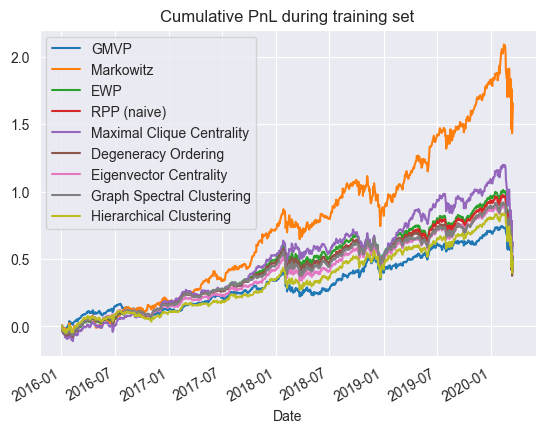

In [46]:
pnl_trn = emp.cum_returns(ret_all_trn)
pnl_trn.index = log_returns.index[:T_trn]
pnl_trn.plot(title="Cumulative PnL during training set")

<Axes: title={'center': 'Cumulative PnL during test set'}, xlabel='Date'>

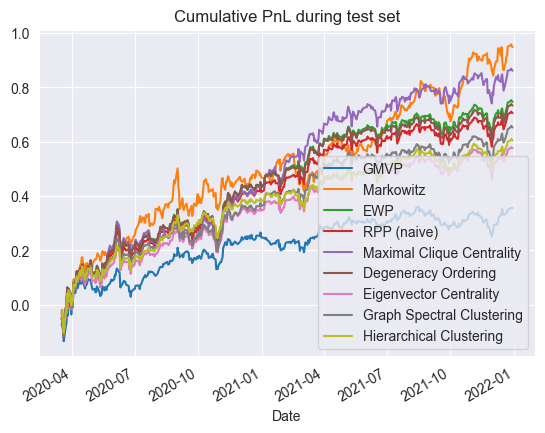

In [47]:
pnl_tst = emp.cum_returns(ret_all_tst)
pnl_tst.index = log_returns.index[T_trn:]
pnl_tst.plot(title="Cumulative PnL during test set")

In [48]:
# compute 8 different set of portfolios from different input data
w_GMVP_acc = []
w_markowitz_acc = []
w_RPP_acc = []
w_cliques_acc = []
w_degen_acc = []
w_ec_acc = []
w_gsc_acc = []
w_hc_acc = []

for i in range(8):
    # sample means with random samples
    idx = np.random.choice(np.arange(T_trn), int(.5*T_trn))
    mu_ = np.mean(log_returns_train[idx, ], axis=0)
    Sigma_ = np.cov(log_returns_train[idx, ].T)

    # Stock graph with random samples 
    stock_graph_ = create_stock_graph(log_returns.iloc[idx, ], correlation_threshold=.565)

    # design portfolios
    w_markowitz_acc.append(compute_markowitz_portfolio(mu_, Sigma_))
    w_GMVP_acc.append(compute_GMVP(Sigma_))
    w_RPP_acc.append(compute_RPP(Sigma_))
    w_cliques_acc.append(compute_cliques(stock_graph_))
    w_degen_acc.append(compute_degen(stock_graph_))
    w_ec_acc.append(compute_ec(stock_graph_))
    w_gsc_acc.append(compute_gsc(stock_graph_))
    w_hc_acc.append(compute_hc(log_returns.iloc[idx, ]))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10124\792606383.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dissimilarity_matrix, method='complete')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10124\792606383.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dissimilarity_matrix, method='complete')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10124\792606383.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dissimilarity_matrix, method='complete')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10124\792606383.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix

<Axes: title={'center': 'Portfolio allocation'}>

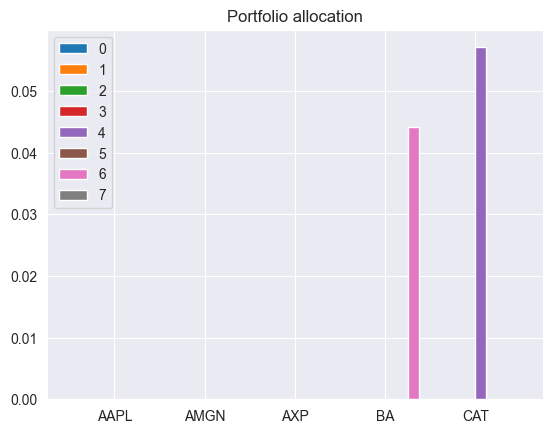

In [49]:
df_GMVP = pd.DataFrame(np.ascontiguousarray(w_GMVP_acc).T, index=stocks)
df_GMVP.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Portfolio allocation'}>

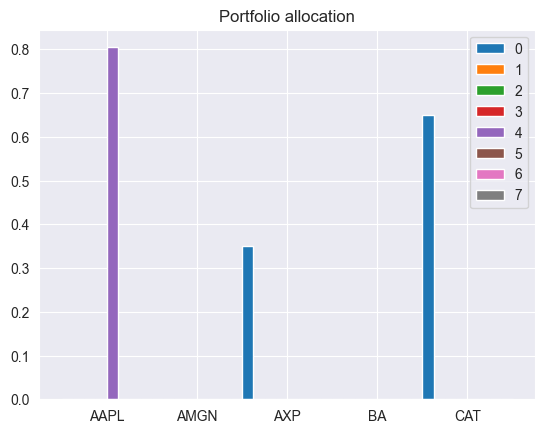

In [50]:
df_markowitz = pd.DataFrame(np.ascontiguousarray(w_markowitz_acc).T, index=stocks)
df_markowitz.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Portfolio allocation'}>

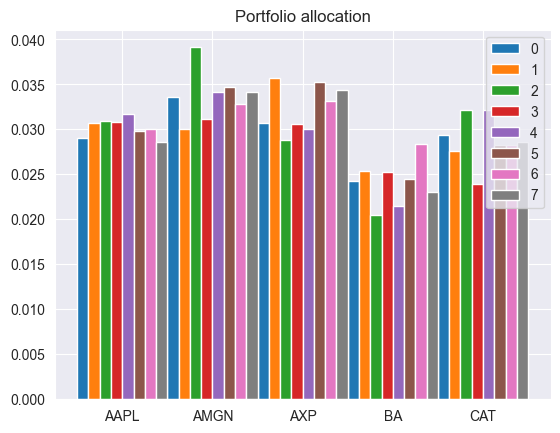

In [51]:
df_RPP = pd.DataFrame(np.ascontiguousarray(w_RPP_acc).T, index=stocks)
df_RPP.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Portfolio allocation'}>

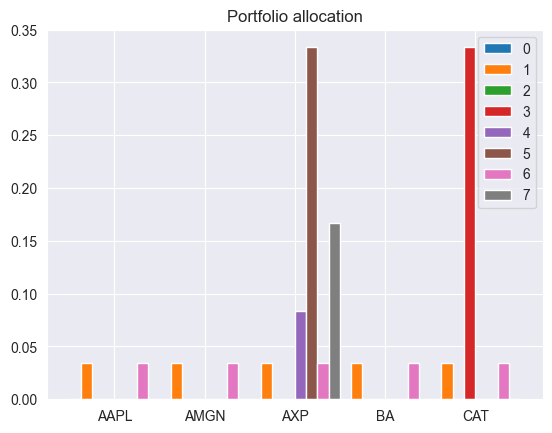

In [52]:
df_cliques = pd.DataFrame(np.ascontiguousarray(w_cliques_acc).T, index=stocks)
df_cliques.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Portfolio allocation'}>

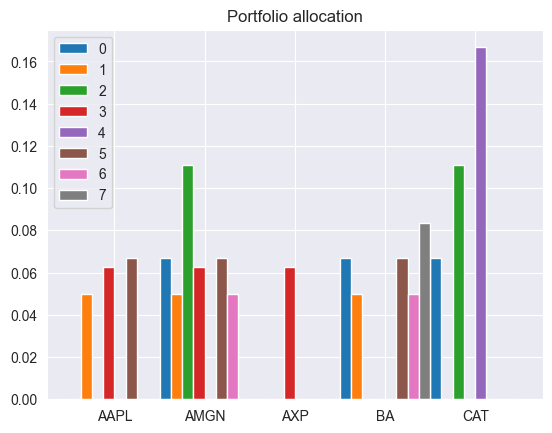

In [53]:
df_degen = pd.DataFrame(np.ascontiguousarray(w_degen_acc).T, index=stocks)
df_degen.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Portfolio allocation'}>

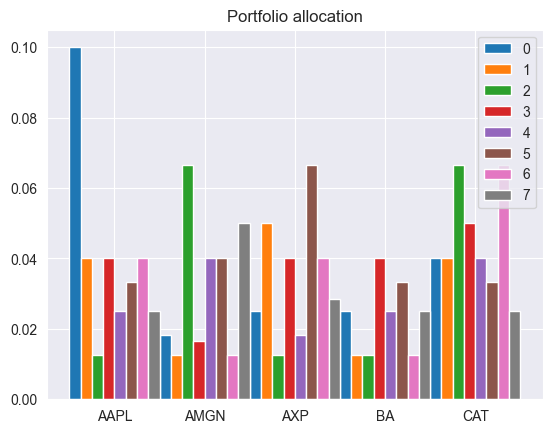

In [54]:
df_ec = pd.DataFrame(np.ascontiguousarray(w_ec_acc).T, index=stocks)
df_ec.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Portfolio allocation'}>

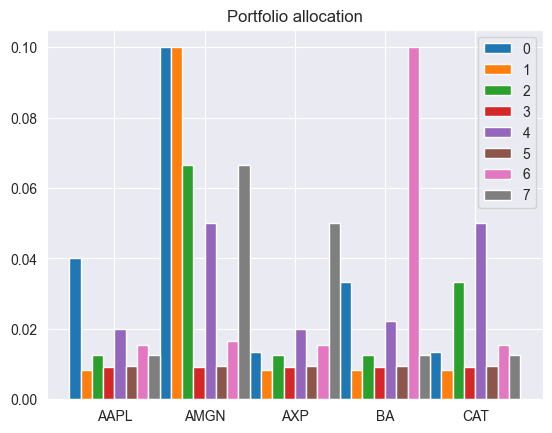

In [55]:
df_gsc = pd.DataFrame(np.ascontiguousarray(w_gsc_acc).T, index=stocks)
df_gsc.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Portfolio allocation'}>

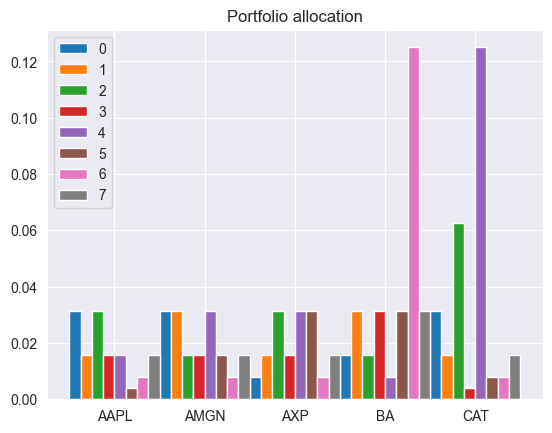

In [56]:
df_hc = pd.DataFrame(np.ascontiguousarray(w_hc_acc).T, index=stocks)
df_hc.iloc[:5].plot.bar(rot=0, width=1, title="Portfolio allocation")

<Axes: title={'center': 'Relative risk contributions'}>

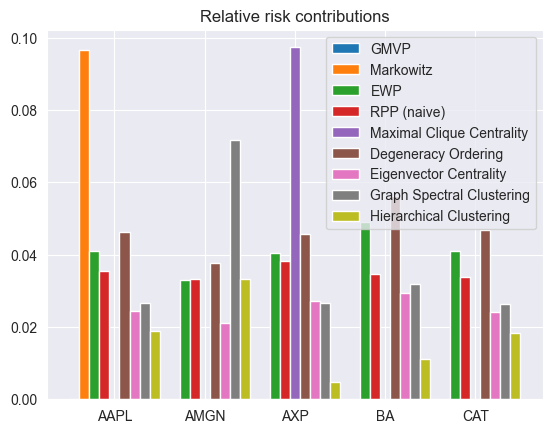

In [57]:
# compute risk contributions
risk_all = pd.DataFrame(np.asarray([w_GMVP * (Sigma @ w_GMVP),
                                    w_markowitz * (Sigma @ w_markowitz),
                                    w_EWP * (Sigma @ w_EWP),
                                    w_RPP_naive * (Sigma @ w_RPP_naive),
                                    w_cliques * (Sigma @ w_cliques),
                                    w_degen * (Sigma @ w_degen),
                                    w_ec * (Sigma @ w_ec),
                                    w_gsc * (Sigma @ w_gsc),
                                    w_hc * (Sigma @ w_hc),
                                    
                        ]).T,
                        columns=[
                            'GMVP', 'Markowitz', 'EWP', 'RPP (naive)',
                            'Maximal Clique Centrality', 'Degeneracy Ordering', 'Eigenvector Centrality',
                            'Graph Spectral Clustering', 'Hierarchical Clustering'
                        ], index=stocks)

normalized_risk = risk_all / risk_all.sum(axis=0)
normalized_risk.iloc[:5].plot.bar(rot=0, title="Relative risk contributions", width=1)